In [1]:
import pandas as pd
import numpy as np

import pickle
import json
import importlib
import xgboost as xgb

import matplotlib.pyplot as plt
import japanize_matplotlib

In [2]:
import common

# モジュールの再読み込み
importlib.reload(common)

_common = common.Common()
_common.BASE_PATH

PosixPath('/Users/iwasakitakahiro/github')

In [3]:
train_df = pd.read_csv('../output/中間データ/学習用データ/train_preprocessed.csv')
test_df = pd.read_csv('../output/中間データ/評価用データ/test_preprocessed.csv')

In [4]:
SEQ_LEN = 24

# --- train_df の最後の SEQ_LEN 行を取得 ---
# ※train_dfには TARGET_COL がある前提
tail_train = train_df.iloc[-SEQ_LEN:].drop(columns=[_common.TARGET_COL])

# --- test_df はそのまま使う（TARGET_COL は含まれていない前提） ---
# tail_train の列と一致していることを確認して連結
concat_test = np.vstack([tail_train.values, test_df[tail_train.columns].values])

# --- DataFrame に戻す ---
test_df = pd.DataFrame(concat_test, columns=tail_train.columns)

## Trend

In [5]:
test_df[_common.UNIQUE_KEY_COLS] = pd.to_datetime(test_df[_common.UNIQUE_KEY_COLS])
test_df = test_df.sort_values(_common.UNIQUE_KEY_COLS).set_index(_common.UNIQUE_KEY_COLS)

test_trend_df = test_df.resample('D').mean().reset_index()

In [6]:
for col in ['weighted_wind_speed','weighted_temp', 'weighted_pressure', 'weighted_humidity', 'weighted_clouds_all']:
    test_trend_df[f'{col}_roll30'] = test_trend_df[col].rolling(window=30, min_periods=15).mean()

In [7]:
with open('../output/モデル/trend_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
model1 = loaded_model['model']
model1_col = loaded_model['feature_name']

In [8]:
test_trend_df['weight'] = 1
X_test_trend = test_trend_df[model1_col]

In [9]:
X_test_trend = X_test_trend[model1_col].astype(float)
y_pred_trend = model1.predict(X_test_trend)

In [10]:
test_df =test_df.reset_index()
test_df['date'] = test_df[_common.UNIQUE_KEY_COLS].dt.date

# ▼ y_pred_trend を 'date' 列付きで DataFrame にする（日単位の予測）
# 例: 2018年1月1日から始まる場合
trend_day_df = pd.DataFrame({
    'date': pd.date_range(start=test_df['date'].min(), periods=len(X_test_trend), freq='D').date,
    'trend': y_pred_trend
})

# ▼ 日付でマージ
test_df = test_df.merge(trend_day_df, on='date', how='left')

## Seasonal

In [11]:
seasonal_table = pd.read_csv('seasonal_table.csv')

In [12]:
test_df['weekday'] = test_df[_common.UNIQUE_KEY_COLS].dt.weekday
test_df['hour'] = test_df[_common.UNIQUE_KEY_COLS].dt.hour

In [13]:
# test_df に weekday/hour をキーにして seasonal をマージ
test_df = test_df.merge(
    seasonal_table,  # または seasonal_table[['weekday', 'hour', 'seasonal']] でもOK
    on=['weekday', 'hour'],
    how='left'
)

## Residual

In [14]:
from tensorflow.keras.models import load_model

# モデル本体
residual_model = load_model('../output/モデル/residual_model.keras')

In [20]:
import joblib

# 読み込み
data = joblib.load('scaler_residual_model.pkl')
scaler = data['scaler']
features = data['features']

# 読み込み
test_features_scaled = pd.DataFrame(
    scaler.transform(test_df[features]),
    columns=features,
    index=test_df.index  # 必要であればindexも保持
)

In [17]:
fe_dynamic = [
    'total_load_actual', 'gene_sum',
    'sus_rate', 'fossil_rate', 'gene_load_ratio', 'gene_cost', 
    'residual_demand', 'residual_demand_ratio', 'w_gene_cost', 'high_cost_ratio', 
    'hour', 'weekday', 'month', 
    'gene_sum_lag1', 'gene_sum_lag24', 'gene_sum_lag48', 'gene_sum_lag72', 
    'gene_sum_rolling_mean168', 'gene_sum_rolling_mean336', 
    # 'gene_sum_rolling_mean672',
    'total_load_actual_lag1', 'total_load_actual_lag24', 'total_load_actual_lag48', 'total_load_actual_lag72',
    'total_load_actual_rolling_mean168', 'total_load_actual_rolling_mean336',
    # 'total_load_actual_rolling_mean672',
    'weighted_wind_speed','weighted_temp', 'weighted_pressure', 'weighted_humidity', 'weighted_clouds_all', 
    # 'encoded_price_weekday_hour',
    # 'valencia_weather_main_LabelEn', 'madrid_weather_main_LabelEn', 
    # 'bilbao_weather_main_LabelEn', 'barcelona_weather_main_LabelEn', 'seville_weather_main_LabelEn', 
    'trend', 'seasonal'
]

fe_static = ['trend', 'seasonal']

In [22]:
# --- テストデータの入力分割 ---
# dynamic部分（trendとseasonalを除いた時系列特徴量）
dynamic_test_scaled = test_features_scaled[fe_dynamic].values
static_test_scaled = test_features_scaled[fe_static].values

# --- 時系列データと静的データに分割 ---
X_seq_test = []
X_static_test = []

for i in range(len(dynamic_test_scaled) - SEQ_LEN):
    X_seq_test.append(dynamic_test_scaled[i:i+SEQ_LEN])          # (24, 動的特徴量数)
    X_static_test.append(static_test_scaled[i+SEQ_LEN])          # (静的特徴量数,)

X_seq_test = np.array(X_seq_test)        # shape: (n_samples, 24, d)
X_static_test = np.array(X_static_test)  # shape: (n_samples, 2)

# --- 予測 ---
y_pred_residual = residual_model.predict([X_seq_test, X_static_test]).flatten()

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [23]:
trend_values = test_df['trend'].iloc[SEQ_LEN:].values
seasonal_values = test_df['seasonal'].iloc[SEQ_LEN:].values

In [24]:
y_pred = y_pred_residual + trend_values + seasonal_values

## 予測結果の出力

In [25]:
result_df = pd.read_csv('../input/提出用データ/sample_submit.csv', header=None)

/var/folders/sb/t91v_nzj05sbsfnhcjb832xr0000gn/T/ipykernel_61758/2951004597.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[47.63613755 55.58922852 53.01039615 ... 62.69798219 41.64876607
 33.62502123]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result_df.iloc[:, 1] = y_pred


                           0          1
0  2018-01-01 00:00:00+01:00  47.636138
1  2018-01-01 01:00:00+01:00  55.589229
2  2018-01-01 02:00:00+01:00  53.010396
3  2018-01-01 03:00:00+01:00  51.492917
4  2018-01-01 04:00:00+01:00  48.955586


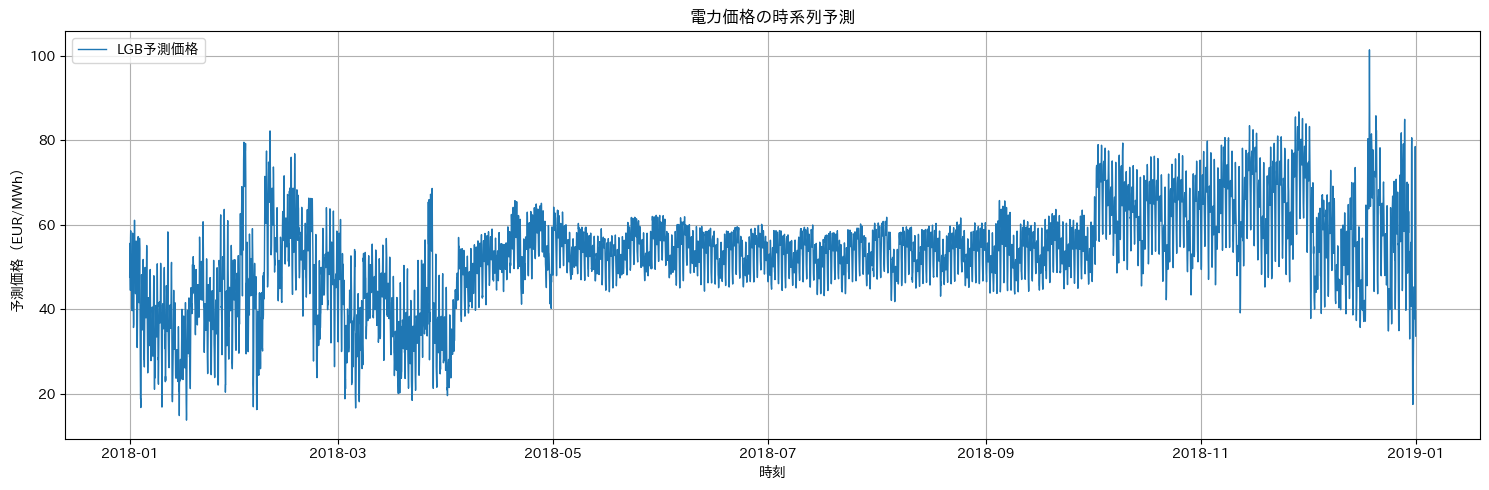

In [ ]:
result_df.iloc[:, 1] = y_pred
result_df.to_csv('../output/予測結果/予測結果_nowostarski.csv', index=False)
print(result_df.head())

# time列をdatetime型に変換
result_df.iloc[:, 0] = pd.to_datetime(result_df.iloc[:, 0], utc=True)

# プロット
plt.figure(figsize=(15, 5))
plt.plot(result_df.iloc[:, 0], result_df.iloc[:, 1], linewidth=1)

plt.xlabel('時刻')
plt.ylabel('予測価格（EUR/MWh）')
plt.title('電力価格の時系列予測')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Continuous Price

In [ ]:
test_df = test_df.iloc[SEQ_LEN:]

/var/folders/sb/t91v_nzj05sbsfnhcjb832xr0000gn/T/ipykernel_61758/3366448851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['residual'] = y_pred_residual


In [35]:
test_df['intraday_price'] = y_pred_residual
test_df['weight'] = 1

/var/folders/sb/t91v_nzj05sbsfnhcjb832xr0000gn/T/ipykernel_61758/2085962957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['intraday_price'] = y_pred_residual
/var/folders/sb/t91v_nzj05sbsfnhcjb832xr0000gn/T/ipykernel_61758/2085962957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['weight'] = 1


In [33]:
# モデル読み込み
with open('../output/モデル/continuous_price_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

model3 = loaded_model['model']
model3_col = loaded_model['feature_name']

In [38]:
X_test_continuous = test_df[model3_col].astype(float)

In [39]:
# X_test を DMatrix に変換
dtest = xgb.DMatrix(X_test_continuous)

# 予測実行
y_pred_continuous = model3.predict(dtest)

In [44]:
y_final_pred = y_pred_residual + trend_values + seasonal_values + y_pred_continuous
result_df['y_final_pred'] = y_final_pred

In [46]:
y_pred_continuous

array([-31.356733, -34.51783 , -38.496075, ..., -20.030806, -24.224234,
       -25.590263], dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


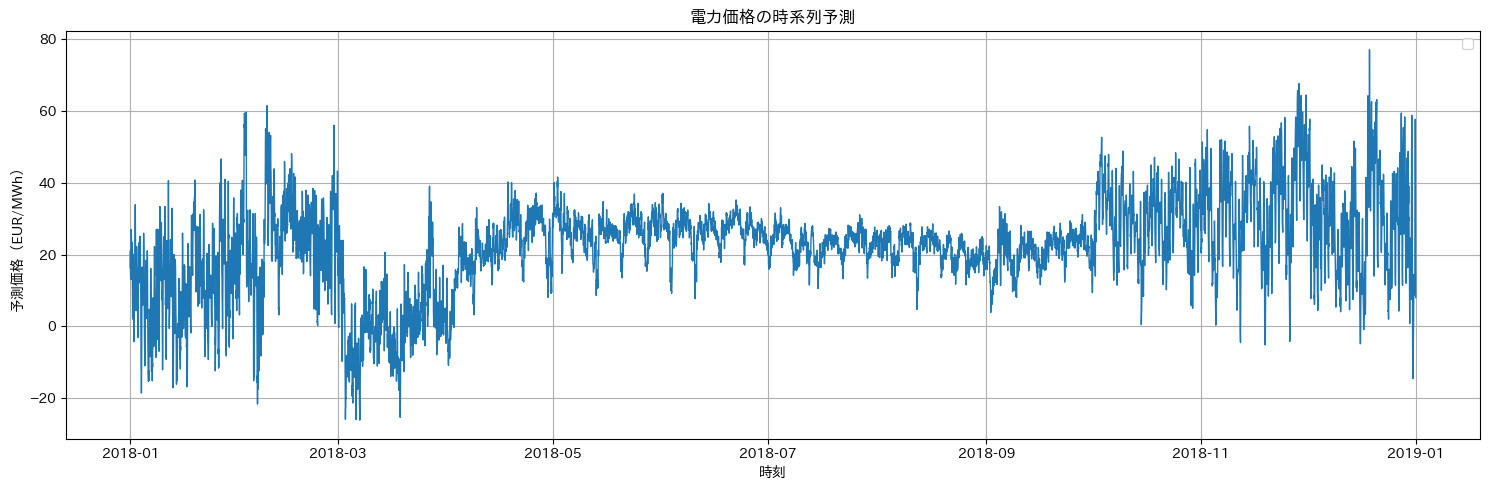

In [43]:
# プロット
plt.figure(figsize=(15, 5))
plt.plot(result_df.iloc[:, 0], result_df.iloc[:, 2], linewidth=1)

plt.xlabel('時刻')
plt.ylabel('予測価格（EUR/MWh）')
plt.title('電力価格の時系列予測')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()